In [73]:
pd.set_option('display.max_columns', None)

In [7]:
from pandas_profiling import ProfileReport

In [8]:
ProfileReport(all_data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
ProfileReport(all_data_final)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Starting :

In [4]:
import re
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy
#pipe
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
#Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
#Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, make_scorer

In [5]:
all_data = pd.read_csv("train_ml.csv", index_col=0)

all_data_final = pd.read_csv("test_ml.csv", index_col=0)

In [6]:
def tlds_extraction(data):
    tlds = {}
    X = deepcopy(data)
    X.tld = X.tld.apply(str)
    for word in X.tld:
        processed = word.lower().strip().split('.')
        for w in processed :
            tlds[w] = 1        
    return tlds

def orgs_extraction(data):
    orgs = {}
    X = deepcopy(data)
    X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
    for org in X.org :
        orgs[org] = 1
    return orgs

imp_tlds = set(tlds_extraction(all_data_final))
imp_orgs = set(orgs_extraction(all_data_final))

In [7]:
all_data.describe()

ccs         bcced        images          urls   salutations  \
count  39671.000000  39671.000000  39671.000000  39671.000000  39671.000000   
mean       0.378967      0.002974      9.806332     36.731088      0.395755   
std        2.530353      0.054458    440.393286    144.379127      0.489018   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      4.500000      0.000000   
50%        0.000000      0.000000      2.000000     18.000000      0.000000   
75%        0.000000      0.000000      9.000000     47.000000      1.000000   
max      155.000000      1.000000  83480.000000  21540.000000      1.000000   

        designation  chars_in_subject  chars_in_body       updates  \
count  39671.000000      39660.000000   3.967100e+04  39671.000000   
mean       0.102317         51.442032   2.321781e+05      0.362406   
std        0.303068         34.142227   2.251044e+06      0.480701   
min        0.000000          0.000000   4.000000e+00      0.000000   
25%        0.000000         31.000000   4.903000e+03      0.000000   
50%        0.000000         43.000000   2.000500e+04      0.000000   
75%        0.000000         63.000000   4.800100e+04      1.000000   
max        1.000000        528.000000   7.438108e+07      1.000000   

           personal    promotions        forums     purchases        travel  \
count  39671.000000  39671.000000  39671.000000  39671.000000  39671.000000   
mean       0.809609      0.199768      0.155807      0.008293      0.002521   
std        0.392614      0.399831      0.362676      0.090690      0.050144   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               spam        social  
count  39671.000000  39671.000000  
mean       0.003832      0.100955  
std        0.061781      0.301273  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [8]:
all_data.head()

date               org            tld  \
0  Mon, 15 Oct 2018 08:03:09 +0000 (UTC)  researchgatemail            net   
1  Thu, 17 Apr 2014 09:12:33 -0700 (PDT)             no-ip            com   
2        Thu, 27 Oct 2016 01:36:28 +0000              mail  goodreads.com   
3  Fri, 16 Oct 2020 08:06:31 +0000 (GMT)       insideapple      apple.com   
4        Thu, 02 Jul 2015 10:16:46 +0000           twitter            com   

   ccs  bcced              mail_type  images  urls  salutations  designation  \
0    0      0  multipart/alternative       4    28            0            1   
1    0      0  multipart/alternative       6    32            0            0   
2    0      0        multipart/mixed       0     0            0            0   
3    0      0  multipart/alternative     108   171            0            0   
4    0      0  multipart/alternative      20   166            0            0   

   chars_in_subject  chars_in_body  updates  personal  promotions  forums  \
0              47.0          25556        0         1           0       0   
1              46.0          19930        1         1           0       0   
2              21.0              4        0         1           0       0   
3              52.0          96568        0         0           1       0   
4              81.0          95131        0         1           0       0   

   purchases  travel  spam  social  
0          0       0     0       1  
1          0       0     0       0  
2          0       0     0       1  
3          0       0     0       0  
4          0       0     0       1

### Lets create more features :

In [9]:
all_data["sub/body"] = all_data.chars_in_subject / all_data.chars_in_body
all_data["urls/body"] = all_data.urls/all_data.chars_in_body
all_data["images/body"] = all_data.images/all_data.chars_in_body
all_data["salutaions&designation"] = all_data.salutations*all_data.designation

all_data_final["sub/body"] = all_data_final.chars_in_subject / all_data_final.chars_in_body
all_data_final["urls/body"] = all_data_final.urls/all_data_final.chars_in_body
all_data_final["images/body"] = all_data_final.images/all_data_final.chars_in_body
all_data_final["salutaions&designation"] = all_data_final.salutations*all_data_final.designation


all_data = all_data.fillna(value=0)
all_data_final = all_data_final.fillna(value=0)

'''
#Ordering columns
n_added_columns = 4
cols = all_data.columns.tolist()
all_data = all_data[cols[-n_added_columns:] + cols[:-n_added_columns]]
''' 

'\n#Ordering columns\nn_added_columns = 4\ncols = all_data.columns.tolist()\nall_data = all_data[cols[-n_added_columns:] + cols[:-n_added_columns]]\n'

<AxesSubplot:>

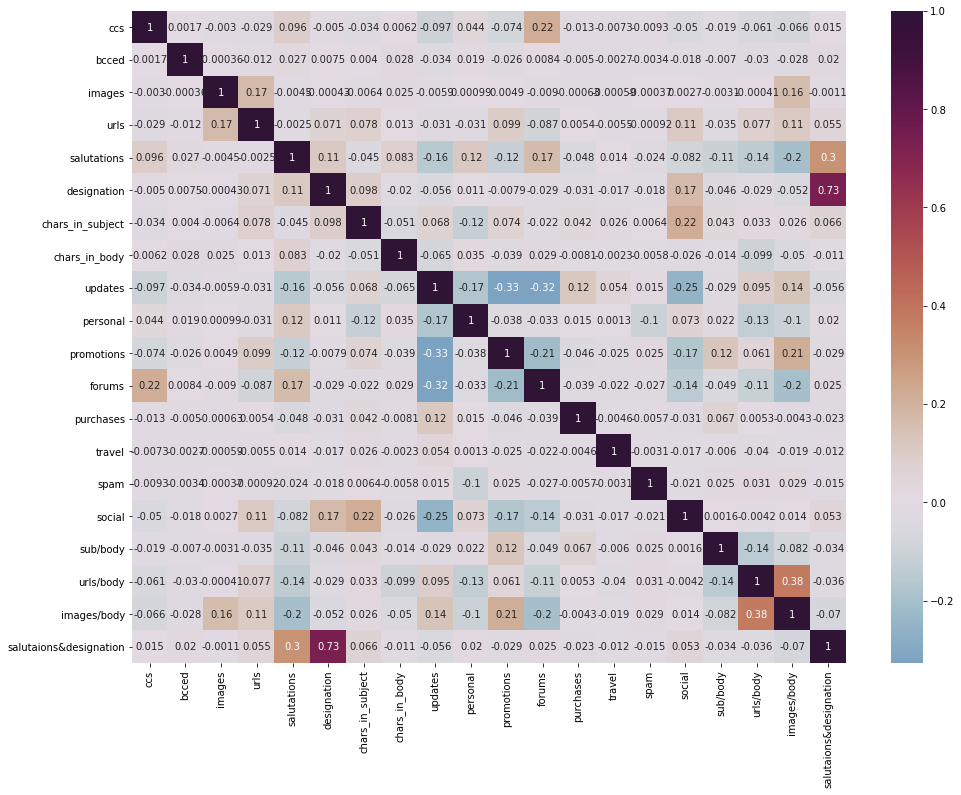

In [10]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(all_data.corr(),cmap = "twilight_shifted", annot=True, ax=ax, center=0)

### Date formatting

In [11]:
def format_date(row):
    pattern = r'(\d{1,2}.*\d{2}:\d{2}:\d{2}) ([+-]\d{2}\d{2})'
    
    ans = re.search(pattern, string=row)
    
    if ans:
        if ans.group(1)[1] == ' ':
            return ''.join(['0', ans.group(1), ans.group(2)])
        else:
            return ''.join([ans.group(1), ans.group(2)])
    else:
        return "08 Oct 1999 00:00:00+2020"

#The for loops are slow :
class DateEncoder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        X = deepcopy(data)
        X['date'] = pd.to_datetime(X['date'].apply(format_date))
        tmp_1 = []
        tmp_2 = []
        tmp_3 = []
        tmp_4 = []
        tmp_5 = []
        tmp_6 = []
        tmp_7 = []

        for d in X['date']:
            tmp_1.append(int(d.strftime("%w")))
            tmp_2.append(int(d.strftime("%H")))
            tmp_3.append(int(d.strftime("%m")))
            tmp_4.append(int(d.strftime("%y")))
            tmp_5.append(d.strftime("%z"))
            tmp_6.append(int(d.strftime("%d")))
            tmp_7.append(int(d.strftime("%M")))

        X['date_dayweek'] = tmp_1
        X['date_hour'] = tmp_2
        X['date_month'] = tmp_3
        X['date_year'] = tmp_4
        X['date_timezone'] = tmp_5
        X['date_daymonth'] = tmp_6
        X['date_minutes'] = tmp_7

        
        X = X.drop(columns=['date'])

        return X

date_column_transformer = make_column_transformer((OneHotEncoder(sparse=0, handle_unknown='ignore'), ['date_timezone']), remainder="passthrough")
date_pipe = make_pipeline(DateEncoder(), date_column_transformer)

date_pipe.fit(pd.DataFrame(all_data["date"]))

'''       
all_data['date'] = pd.to_datetime(all_data['date'].apply(format_date))
tmp_1 = []
tmp_2 = []
tmp_3 = []
tmp_4 = []
tmp_5 = []
tmp_6 = []

for d in all_data['date']:
    tmp_1.append(d.strftime("%w"))
    tmp_2.append(d.strftime("%H"))
    tmp_3.append(d.strftime("%m"))
    tmp_4.append(d.strftime("%y"))
    tmp_5.append(d.strftime("%z"))
    tmp_6.append(d.strftime("%d"))

all_data['date_dayweek'] = tmp_1
all_data['date_hour'] = tmp_2
all_data['date_month'] = tmp_3
all_data['date_year'] = tmp_4
all_data['date_timezone'] = tmp_5
all_data['date_daymonth'] = tmp_6

#Test data

all_data_final['date'] = pd.to_datetime(all_data_final['date'].apply(format_date))
tmp_1 = []
tmp_2 = []
tmp_3 = []
tmp_4 = []
tmp_5 = []
tmp_6 = []
for d in all_data_final['date']:
    tmp_1.append(d.strftime("%w"))
    tmp_2.append(d.strftime("%H"))
    tmp_3.append(d.strftime("%m"))
    tmp_4.append(d.strftime("%y"))
    tmp_5.append(d.strftime("%z"))
    tmp_6.append(d.strftime("%d"))
    
all_data_final['date_dayweek'] = tmp_1
all_data_final['date_hour'] = tmp_2
all_data_final['date_month'] = tmp_3
all_data_final['date_year'] = tmp_4
all_data_final['date_timezone'] = tmp_5
all_data_final['date_daymonth'] = tmp_6
'''

'       \nall_data[\'date\'] = pd.to_datetime(all_data[\'date\'].apply(format_date))\ntmp_1 = []\ntmp_2 = []\ntmp_3 = []\ntmp_4 = []\ntmp_5 = []\ntmp_6 = []\n\nfor d in all_data[\'date\']:\n    tmp_1.append(d.strftime("%w"))\n    tmp_2.append(d.strftime("%H"))\n    tmp_3.append(d.strftime("%m"))\n    tmp_4.append(d.strftime("%y"))\n    tmp_5.append(d.strftime("%z"))\n    tmp_6.append(d.strftime("%d"))\n\nall_data[\'date_dayweek\'] = tmp_1\nall_data[\'date_hour\'] = tmp_2\nall_data[\'date_month\'] = tmp_3\nall_data[\'date_year\'] = tmp_4\nall_data[\'date_timezone\'] = tmp_5\nall_data[\'date_daymonth\'] = tmp_6\n\n#Test data\n\nall_data_final[\'date\'] = pd.to_datetime(all_data_final[\'date\'].apply(format_date))\ntmp_1 = []\ntmp_2 = []\ntmp_3 = []\ntmp_4 = []\ntmp_5 = []\ntmp_6 = []\nfor d in all_data_final[\'date\']:\n    tmp_1.append(d.strftime("%w"))\n    tmp_2.append(d.strftime("%H"))\n    tmp_3.append(d.strftime("%m"))\n    tmp_4.append(d.strftime("%y"))\n    tmp_5.append(d.strftim

In [12]:
XX = date_pipe.transform(pd.DataFrame(all_data["date"]))

In [13]:
XX = pd.DataFrame(XX)

XX.describe()

0             1             2             3             4   \
count  39671.000000  39671.000000  39671.000000  39671.000000  39671.000000   
mean       0.443649      0.022636      0.036173      0.001210      0.000025   
std        0.496821      0.148743      0.186722      0.034764      0.005021   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5            6             7            8             9   \
count  39671.000000  39671.00000  39671.000000  39671.00000  39671.000000   
mean       0.000176      0.00005      0.296514      0.00005      0.000025   
std        0.013282      0.00710      0.456726      0.00710      0.005021   
min        0.000000      0.00000      0.000000      0.00000      0.000000   
25%        0.000000      0.00000      0.000000      0.00000      0.000000   
50%        0.000000      0.00000      0.000000      0.00000      0.000000   
75%        0.000000      0.00000      1.000000      0.00000      0.000000   
max        1.000000      1.00000      1.000000      1.00000      1.000000   

       ...            19            20            21            22  \
count  ...  39671.000000  39671.000000  39671.000000  39671.000000   
mean   ...      0.028988      0.022888      0.084066      0.031232   
std    ...      0.167776      0.149549      0.277491      0.173946   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

                 23            24            25            26            27  \
count  39671.000000  39671.000000  39671.000000  39671.000000  39671.000000   
mean       3.077916     11.619395      6.607068     17.291119     15.424340   
std        1.826134      6.070791      3.329433      3.667326      8.827711   
min        0.000000      0.000000      1.000000     12.000000      1.000000   
25%        2.000000      7.000000      4.000000     16.000000      8.000000   
50%        3.000000     12.000000      7.000000     17.000000     15.000000   
75%        5.000000     16.000000      9.000000     19.000000     23.000000   
max        6.000000     23.000000     12.000000     99.000000     31.000000   

                 28  
count  39671.000000  
mean      28.200222  
std       17.623013  
min        0.000000  
25%       13.000000  
50%       28.000000  
75%       43.000000  
max       59.000000  

[8 rows x 29 columns]

### String formatting and encoding

For training data

In [14]:
class MailTypeEncoder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        X = deepcopy(data)

        multipart = []
        alternative = []
        text = []
        mixed = []
        signed = []
        html = []
        plain = []
        calendar = []
        related = []
        report = []

        for mtype in X.mail_type.values :
            mtype = str(mtype)
            multipart.append( "multipart" in mtype.lower())
            alternative.append( "alternative" in mtype.lower())
            text.append( "text" in mtype.lower())
            mixed.append( "mixed" in mtype.lower())
            signed.append( "signed" in mtype.lower())
            html.append( "html" in mtype.lower())
            plain.append( "plain" in mtype.lower())
            calendar.append( "calendar" in mtype.lower())
            related.append( "related" in mtype.lower())
            report.append( "report" in mtype.lower())

        #Encoding
        X["multipart"] = multipart
        X["alternative"] = alternative
        X["text"] = text
        X["mixed"] = mixed
        X["signed"] = signed
        X["html"] = html
        X["plain"] = plain
        X["calendar"] = calendar
        X["related"] = related
        X["report"] = report
        
        X = X.drop(columns=['mail_type'])
        
        return X

"""
    all_data.mail_type = all_data.mail_type.fillna(value="")

    multipart = []
    alternative = []
    text = []
    mixed = []
    signed = []
    html = []
    plain = []
    calendar = []
    related = []
    report = []

    for type in all_data.mail_type.values :
        multipart.append( "multipart" in type.lower())
        alternative.append( "alternative" in type.lower())
        text.append( "text" in type.lower())
        mixed.append( "mixed" in type.lower())
        signed.append( "signed" in type.lower())
        html.append( "html" in type.lower())
        plain.append( "plain" in type.lower())
        calendar.append( "calendar" in type.lower())
        related.append( "related" in type.lower())
        report.append( "report" in type.lower())

    #Encoding
    all_data["multipart"] = multipart
    all_data["alternative"] = alternative
    all_data["text"] = text
    all_data["mixed"] = mixed
    all_data["signed"] = signed
    all_data["html"] = html
    all_data["plain"] = plain
    all_data["calendar"] = calendar
    all_data["related"] = related
    all_data["report"] = report

    '''
    np.unique(all_data.mail_type.values)

    ==> array(['', 'Multipart/Alternative', 'Multipart/Mixed', 'Text/Html',
           'multipart/IDM', 'multipart/alternative', 'multipart/mixed',
           'multipart/related', 'multipart/report', 'multipart/signed',
           'text/HTML', 'text/calendar', 'text/html', 'text/html ',
           'text/plain'], dtype=object)
    '''

    #Free some memory 
    multipart, alternative, text, mixed, signed, html, plain, calendar, related, report = 0,0,0,0,0,0,0,0,0,0
"""

'\n    all_data.mail_type = all_data.mail_type.fillna(value="")\n\n    multipart = []\n    alternative = []\n    text = []\n    mixed = []\n    signed = []\n    html = []\n    plain = []\n    calendar = []\n    related = []\n    report = []\n\n    for type in all_data.mail_type.values :\n        multipart.append( "multipart" in type.lower())\n        alternative.append( "alternative" in type.lower())\n        text.append( "text" in type.lower())\n        mixed.append( "mixed" in type.lower())\n        signed.append( "signed" in type.lower())\n        html.append( "html" in type.lower())\n        plain.append( "plain" in type.lower())\n        calendar.append( "calendar" in type.lower())\n        related.append( "related" in type.lower())\n        report.append( "report" in type.lower())\n\n    #Encoding\n    all_data["multipart"] = multipart\n    all_data["alternative"] = alternative\n    all_data["text"] = text\n    all_data["mixed"] = mixed\n    all_data["signed"] = signed\n    all_d

For test data

In [15]:
'''
    all_data_final.mail_type = all_data_final.mail_type.fillna(value="")

    multipart = []
    alternative = []
    text = []
    mixed = []
    signed = []
    html = []
    plain = []
    calendar = []
    related = []
    report = []

    for type in all_data_final.mail_type.values :
        multipart.append( "multipart" in type.lower())
        alternative.append( "alternative" in type.lower())
        text.append( "text" in type.lower())
        mixed.append( "mixed" in type.lower())
        signed.append( "signed" in type.lower())
        html.append( "html" in type.lower())
        plain.append( "plain" in type.lower())
        calendar.append( "calendar" in type.lower())
        related.append( "related" in type.lower())
        report.append( "report" in type.lower())

    #Encoding
    all_data_final["multipart"] = multipart
    all_data_final["alternative"] = alternative
    all_data_final["text"] = text
    all_data_final["mixed"] = mixed
    all_data_final["signed"] = signed
    all_data_final["html"] = html
    all_data_final["plain"] = plain
    all_data_final["calendar"] = calendar
    all_data_final["related"] = related
    all_data_final["report"] = report

    """
    np.unique(all_data_final.mail_type.values)

    ==> array(['', 'Multipart/Mixed', 'Text/Html', 'multipart/alternative',
           'multipart/mixed', 'multipart/related', 'multipart/report',
           'multipart/signed', 'text/html', 'text/html ', 'text/plain'],
          dtype=object)
    """

    #Free some memory 
    multipart, alternative, text, mixed, signed, html, plain, calendar, related, report = 0,0,0,0,0,0,0,0,0,0
'''

'\n    all_data_final.mail_type = all_data_final.mail_type.fillna(value="")\n\n    multipart = []\n    alternative = []\n    text = []\n    mixed = []\n    signed = []\n    html = []\n    plain = []\n    calendar = []\n    related = []\n    report = []\n\n    for type in all_data_final.mail_type.values :\n        multipart.append( "multipart" in type.lower())\n        alternative.append( "alternative" in type.lower())\n        text.append( "text" in type.lower())\n        mixed.append( "mixed" in type.lower())\n        signed.append( "signed" in type.lower())\n        html.append( "html" in type.lower())\n        plain.append( "plain" in type.lower())\n        calendar.append( "calendar" in type.lower())\n        related.append( "related" in type.lower())\n        report.append( "report" in type.lower())\n\n    #Encoding\n    all_data_final["multipart"] = multipart\n    all_data_final["alternative"] = alternative\n    all_data_final["text"] = text\n    all_data_final["mixed"] = mixed\n

##### TLD cleaning

In [16]:
class TldEncoder(BaseEstimator):
    def __init__(self, MINIMAL_REPEAT_TLDS=3, only_imp = True):
        self.MINIMAL_REPEAT_TLDS = MINIMAL_REPEAT_TLDS
        self.tlds = {} #We will use a dictionary counting the number of occurance of each tld name
        self.only_imp = only_imp
    def fit(self, data, y=None):
        self.tlds = {} #initialisation
        X = deepcopy(data)
        X.tld = X.tld.apply(str)
        
        for word in X.tld :
            processed = word.lower().strip().split('.')
            for w in processed :
                try :
                    self.tlds[w] += 1
                except: #w is not yet in the dictionary 
                    self.tlds[w] = 1
        tlds = deepcopy(self.tlds)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in tlds:
                if word not in imp_tlds:
                    del(self.tlds[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)        
        X.tld = X.tld.apply(str)
        
        tlds_columns_names = { word : None  for word in filter(lambda x: self.tlds[x]>=self.MINIMAL_REPEAT_TLDS ,self.tlds)}
        tlds_columns = {"tld_" + word : [0]*len(X) for word in tlds_columns_names.keys()}
        tlds_columns["tld_depth"] = [0]*len(X)
        tlds_columns["tld_length"] = [0]*len(X)
        tlds_columns["tld_is_composed"] = [0]*len(X)
        tlds_columns["tld_nums"] = [0]*len(X)


        nums = set("123456789")
        for i,tld in enumerate(X.tld) :
            tlds_columns["tld_depth"][i] = tld.count(".")
            tlds_columns["tld_length"][i] = len(tld)
            tlds_columns["tld_is_composed"][i] = '-' in tld
            tlds_columns["tld_nums"][i] = len(nums.intersection(tld))


            for word in tlds_columns_names.keys() :
                if word in tld.lower():
                    tlds_columns["tld_"+word][i] = 1
        
        X[list(tlds_columns.keys())] = np.array(list(tlds_columns.values())).transpose()
        
        X = X.drop(columns=['tld'])
        
        return X
    

'''
    #We will use a dictionary counting the number of occurance of each tld name
    tlds = {}
    MINIMAL_REPEAT_TLDS = 3
    all_data.tld = all_data.tld.apply(str)
    for word in all_data.tld :
        processed = word.lower().strip().split('.')
        for w in processed :
            try :
                tlds[w] += 1
            except: #w is not yet in the dictionary 
                tlds[w] = 1
    #del(tlds["nan"]) #will we also classify "nan" data ? this might be searched in the future



    #Training

    #This might be searched more concerning the value of MINIMAL_REPEATED
    tlds_columns = { 'tld_'+word : [0]*len(all_data)     for word in filter(lambda x: tlds[x]>=MINIMAL_REPEAT_TLDS ,tlds)}  #This will create a dictionnary of lists, each key correspond to a word
    tlds_columns["tld_depth"] = [0]*len(all_data)

    #Now we will create the columns in all data, we will do an encoding
    for i,tld in enumerate(all_data.tld) :
        tlds_columns["tld_depth"][i] = tld.count(".")
        for word in tlds_columns.keys() :
            if word in tld.lower():
                tlds_columns[word][i] = 1
    #Columns creation
    all_data[list(tlds_columns.keys())] = np.array(list(tlds_columns.values())).transpose()



    #Test
    all_data_final.tld = all_data_final.tld.apply(str)
    tlds_columns = { 'tld_'+word : [0]*len(all_data_final)     for word in filter(lambda x: tlds[x]>=MINIMAL_REPEAT_TLDS ,tlds)}  #This will create a dictionnary of lists, each key correspond to a word
    tlds_columns["tld_depth"] = [0]*len(all_data_final)

    for i,tld in enumerate(all_data_final.tld) :
        tlds_columns["tld_depth"][i] = tld.count(".")
        for word in tlds_columns.keys() :
            if word in tld.lower():
                tlds_columns[word][i] = 1
    #Columns creation
    all_data_final[list(tlds_columns.keys())] = np.array(list(tlds_columns.values())).transpose()


    #Free some memory
    tlds = 0
    tlds_columns = 0
'''

'\n    #We will use a dictionary counting the number of occurance of each tld name\n    tlds = {}\n    MINIMAL_REPEAT_TLDS = 3\n    all_data.tld = all_data.tld.apply(str)\n    for word in all_data.tld :\n        processed = word.lower().strip().split(\'.\')\n        for w in processed :\n            try :\n                tlds[w] += 1\n            except: #w is not yet in the dictionary \n                tlds[w] = 1\n    #del(tlds["nan"]) #will we also classify "nan" data ? this might be searched in the future\n\n\n\n    #Training\n\n    #This might be searched more concerning the value of MINIMAL_REPEATED\n    tlds_columns = { \'tld_\'+word : [0]*len(all_data)     for word in filter(lambda x: tlds[x]>=MINIMAL_REPEAT_TLDS ,tlds)}  #This will create a dictionnary of lists, each key correspond to a word\n    tlds_columns["tld_depth"] = [0]*len(all_data)\n\n    #Now we will create the columns in all data, we will do an encoding\n    for i,tld in enumerate(all_data.tld) :\n        tlds_col

##### ORG cleaning

In [17]:
class OrgEncoder(BaseEstimator):
    def __init__(self, MINIMAL_REPEAT_ORGS = 2, only_imp=True):
        self.MINIMAL_REPEAT_ORGS = MINIMAL_REPEAT_ORGS
        self.orgs = {}
        self.only_imp = only_imp
    def fit(self, data, y=None):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        for org in X.org :
            try:
                self.orgs[org] += 1
            except:
                self.orgs[org] = 1
                
        orgs = deepcopy(self.orgs)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in orgs:
                if word not in imp_orgs:
                    del(self.orgs[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)
        original_org = X.org.apply(str).values
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        orgs_columns_names = { word : None     for word in filter(lambda x: self.orgs[x]>=self.MINIMAL_REPEAT_ORGS,self.orgs)} 
        orgs_columns = { 'org_'+ word : [0]*len(X)     for word in orgs_columns_names.keys()} 
        orgs_columns["org_length"] = [0]*len(X)
        orgs_columns["org_is_composed"] = [0]*len(X)
        orgs_columns["org_nums"] = [0]*len(X)
        
        nums = set('123456789')
        for i,org in enumerate(X.org) :
            orgs_columns["org_length"][i] = len(org)
            orgs_columns["org_is_composed"][i] = '-' in original_org[i]
            orgs_columns["org_nums"][i] = len(nums.intersection(org))
            for word in orgs_columns_names.keys() :
                if word == org.lower():
                    orgs_columns["org_"+word][i] = 1
        #Columns creation
        X[list(orgs_columns.keys())] = np.array(list(orgs_columns.values())).transpose()
        
        X = X.drop(columns=['org'])

        return X
    
class OrgEncoder2(BaseEstimator):
    def __init__(self, MINIMAL_REPEAT_ORGS = 2, only_imp = True):
        self.MINIMAL_REPEAT_ORGS = MINIMAL_REPEAT_ORGS
        self.orgs = {}
        self.only_imp = only_imp
    def fit(self, data, y=None):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        for org in X.org :
            try:
                self.orgs[org] += 1
            except:
                self.orgs[org] = 1
        orgs = deepcopy(self.orgs)
        if self.only_imp: # delete data that doesn't exist on the all_data_final
            for word in orgs:
                if word not in imp_orgs:
                    del(self.orgs[word])
        return self
    
    def transform(self, data):
        X = deepcopy(data)
        X.org = X.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
        
        orgs_columns_names = [word  for word in filter(lambda x: self.orgs[x]>=self.MINIMAL_REPEAT_ORGS,self.orgs)]
        orgs_length = []
        column = [0]*len(X)
        
        for i,org in enumerate(X.org) :
            orgs_length.append(len(org))
            for j in range(len(orgs_columns_names)) :
                if orgs_columns_names[j] == org.lower():
                    column[i] = j+1
        #Columns creation
        X["orgs"] = column
        X["orgs_length"] = orgs_length
        
        X = X.drop(columns=['org'])

        return X
'''
# This dictionnary will count the number of times we have repeated stuff
orgs = {}
MINIMAL_REPEAT_ORGS = 2
all_data.org = all_data.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())

for org in all_data.org :
    try:
        orgs[org] += 1
    except:
        orgs[org] = 1
#del(orgs["nan"]) #will we also classify "nan" data ? this might be searched in the future
        
    
    
#Training

#This might be searched more concerning the value of MINIMAL_REPEATED_ORGS
orgs_columns = { 'org_'+word : [0]*len(all_data)     for word in filter(lambda x: orgs[x]>=MINIMAL_REPEAT_ORGS,orgs)}  #This will create a dictionnary of lists, each key correspond to a word
orgs_columns["org_length"] = [0]*len(all_data)

#Now we will create the columns in all data, we will do an encoding
for i,org in enumerate(all_data.org) :
    orgs_columns["org_length"][i] = len(org)
    for word in orgs_columns.keys() :
        if word == org.lower():
            orgs_columns[word][i] = 1
#Columns creation
all_data[list(orgs_columns.keys())] = np.array(list(orgs_columns.values())).transpose()



#Test

#Same thing as Training
all_data_final.org = all_data_final.org.apply(lambda x: ''.join(l for l in str(x) if l not in '-_ ' ).lower())
orgs_columns = { 'org_'+word : [0]*len(all_data_final)     for word in filter(lambda x: orgs[x]>=MINIMAL_REPEAT_ORGS,orgs)}  #This will create a dictionnary of lists, each key correspond to a word
orgs_columns["org_length"] = [0]*len(all_data_final)

for i,org in enumerate(all_data_final.org) :
    orgs_columns["org_length"][i] = len(org)
    for word in orgs_columns.keys() :
        if word == org.lower():
            orgs_columns[word][i] = 1
#Columns creation
all_data_final[list(orgs_columns.keys())] = np.array(list(orgs_columns.values())).transpose()


#free some memory
orgs = 0
orgs_columns = 0
'''

'\n# This dictionnary will count the number of times we have repeated stuff\norgs = {}\nMINIMAL_REPEAT_ORGS = 2\nall_data.org = all_data.org.apply(lambda x: \'\'.join(l for l in str(x) if l not in \'-_ \' ).lower())\n\nfor org in all_data.org :\n    try:\n        orgs[org] += 1\n    except:\n        orgs[org] = 1\n#del(orgs["nan"]) #will we also classify "nan" data ? this might be searched in the future\n        \n    \n    \n#Training\n\n#This might be searched more concerning the value of MINIMAL_REPEATED_ORGS\norgs_columns = { \'org_\'+word : [0]*len(all_data)     for word in filter(lambda x: orgs[x]>=MINIMAL_REPEAT_ORGS,orgs)}  #This will create a dictionnary of lists, each key correspond to a word\norgs_columns["org_length"] = [0]*len(all_data)\n\n#Now we will create the columns in all data, we will do an encoding\nfor i,org in enumerate(all_data.org) :\n    orgs_columns["org_length"][i] = len(org)\n    for word in orgs_columns.keys() :\n        if word == org.lower():\n          

In [18]:
all_data.head(2)

date               org  tld  ccs  bcced  \
0  Mon, 15 Oct 2018 08:03:09 +0000 (UTC)  researchgatemail  net    0      0   
1  Thu, 17 Apr 2014 09:12:33 -0700 (PDT)             no-ip  com    0      0   

               mail_type  images  urls  salutations  designation  ...  \
0  multipart/alternative       4    28            0            1  ...   
1  multipart/alternative       6    32            0            0  ...   

   promotions  forums  purchases  travel  spam  social  sub/body  urls/body  \
0           0       0          0       0     0       1  0.001839   0.001096   
1           0       0          0       0     0       0  0.002308   0.001606   

   images/body  salutaions&designation  
0     0.000157                       0  
1     0.000301                       0  

[2 rows x 24 columns]

In [19]:
all_data_final.head(2)

date      org          tld  ccs  bcced  \
0  Thu, 13 Jul 2017 08:55:57 +0000  twitter          com    0      0   
1  Sun, 30 Sep 2018 14:42:12 +0000   mailer  netflix.com    0      0   

               mail_type  images  urls  salutations  designation  \
0  multipart/alternative       7    56            0            0   
1  multipart/alternative       5    33            0            0   

   chars_in_subject  chars_in_body  sub/body  urls/body  images/body  \
0              67.0          36243  0.001849   0.001545     0.000193   
1              27.0          27015  0.000999   0.001222     0.000185   

   salutaions&designation  
0                       0  
1                       0

# Vector creation

In [20]:
"""
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']

X = all_data.drop(columns=['date','org','tld','mail_type']+labels)
X = X.fillna(value=0)
y = all_data[labels]

X_final = all_data_final.drop(columns=['date','org','tld','mail_type'])
X_final = X_final.fillna(value=0)
"""

"\nlabels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']\n\nX = all_data.drop(columns=['date','org','tld','mail_type']+labels)\nX = X.fillna(value=0)\ny = all_data[labels]\n\nX_final = all_data_final.drop(columns=['date','org','tld','mail_type'])\nX_final = X_final.fillna(value=0)\n"

In [21]:
"""
All_data = all_data.drop(columns=['date','org','tld','mail_type'])
All_data_final = all_data_final.drop(columns=['date','org','tld','mail_type'])

All_data.to_csv("all_data_for_tony.csv", index=False)
All_data_final.to_csv("all_data_final_for_tony.csv", index=False)
"""

'\nAll_data = all_data.drop(columns=[\'date\',\'org\',\'tld\',\'mail_type\'])\nAll_data_final = all_data_final.drop(columns=[\'date\',\'org\',\'tld\',\'mail_type\'])\n\nAll_data.to_csv("all_data_for_tony.csv", index=False)\nAll_data_final.to_csv("all_data_final_for_tony.csv", index=False)\n'

# Here you should do an approriat encoding


### Creating and encoding X and y vectors :

In [22]:
if False:
    #Categorical Data
    attributes = ['org','tld','mail_type','date','date_hour'] #Categorical data
    cat_data_final =  all_data_final[attributes].fillna(value="None")
    cat_data = all_data[attributes].fillna(value='None')

    #Training and Testing
    X = all_data[['ccs','bcced','images','urls','salutations','designation','chars_in_subject','chars_in_body','sub/body','urls/body','images/body']]

        #Data cleaning
    X = X.fillna(value=0)

        #Encode other data
    enc = OneHotEncoder(sparse=0, handle_unknown='ignore')
    for att in attributes:
        enc.fit( cat_data[att].values.reshape(-1,1)[::10] ) #Fit

        X_tmp_enc = enc.transform( cat_data[att].values.reshape(-1,1) ) #Encoded data
        pd_X_tmp_enc = pd.DataFrame(X_tmp_enc, columns= [att +"_" + category for category in enc.categories_[0]]) 

        X = pd.concat([pd_X_tmp_enc, X], axis=1)

    y = all_data[['updates','personal','promotions','forums','purchases','travel','spam','social']]



    #Predicting
    X_final = all_data_final[['ccs','bcced','images','urls','salutations','designation','chars_in_subject','chars_in_body','sub/body','urls/body','images/body']]

        #Data cleaning
    X_final = X_final.fillna(value=0)
        #Encode other data
    for att in attributes:
        enc.fit( cat_data[att].values.reshape(-1,1)[::10] ) #Fit
        X_tmp_enc = enc.transform( cat_data_final[att].values.reshape(-1,1) ) #Encoding data
        pd_X_tmp_enc = pd.DataFrame(X_tmp_enc, columns= [att +"_" + category for category in enc.categories_[0]]) 

        X_final = pd.concat([pd_X_tmp_enc, X_final], axis=1)



# Model building 

In [53]:
transformations = make_column_transformer((date_pipe, ['date']),
                                (MailTypeEncoder(), ['mail_type']),
                                (TldEncoder(MINIMAL_REPEAT_TLDS = 13, only_imp = True), ['tld']),
                                (OrgEncoder(MINIMAL_REPEAT_ORGS = 2, only_imp = True), ['org']),
                                remainder="passthrough")
model = make_pipeline(transformations, RandomForestClassifier())

In [54]:
transformations.fit(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('dateencoder', DateEncoder()),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse=0),
                                                                                   ['date_timezone'])]))]),
                                 ['date']),
                                ('mailtypeencoder', MailTypeEncoder(),
                                 ['mail_type']),
                                ('tldencoder',
                  

In [55]:
X_final = transformations.transform(all_data_final)

In [56]:
X = transformations.transform(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))


In [57]:
y = all_data[['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']]

In [58]:
all_data

date               org  \
0      Mon, 15 Oct 2018 08:03:09 +0000 (UTC)  researchgatemail   
1      Thu, 17 Apr 2014 09:12:33 -0700 (PDT)             no-ip   
2            Thu, 27 Oct 2016 01:36:28 +0000              mail   
3      Fri, 16 Oct 2020 08:06:31 +0000 (GMT)       insideapple   
4            Thu, 02 Jul 2015 10:16:46 +0000           twitter   
...                                      ...               ...   
39666        Tue, 08 Oct 2019 18:58:39 +0000               mp1   
39667             03 Apr 2018 16:07:48 +0530                 0   
39668         Mon, 3 Apr 2017 18:55:47 +0530             iiitd   
39669        Thu, 14 Jun 2018 00:46:51 +0000                 m   
39670        Fri, 17 Apr 2020 07:06:27 -0700            github   

                     tld  ccs  bcced              mail_type  images  urls  \
0                    net    0      0  multipart/alternative       4    28   
1                    com    0      0  multipart/alternative       6    32   
2          goodreads.com    0      0        multipart/mixed       0     0   
3              apple.com    0      0  multipart/alternative     108   171   
4                    com    0      0  multipart/alternative      20   166   
...                  ...  ...    ...                    ...     ...   ...   
39666    tripadvisor.com    0      0              text/html      11    31   
39667                  0    0      0             text/plain       0     0   
39668              ac.in    0      0  multipart/alternative       0     0   
39669  mail.coursera.org    0      0  multipart/alternative      27   136   
39670                com    0      0             text/plain       0     2   

       salutations  designation  ...  promotions  forums  purchases  travel  \
0                0            1  ...           0       0          0       0   
1                0            0  ...           0       0          0       0   
2                0            0  ...           0       0          0       0   
3                0            0  ...           1       0          0       0   
4                0            0  ...           0       0          0       0   
...            ...          ...  ...         ...     ...        ...     ...   
39666            0            0  ...           1       0          0       0   
39667            0            0  ...           0       0          0       0   
39668            1            0  ...           0       1          0       0   
39669            1            1  ...           0       0          0       0   
39670            0            0  ...           0       0          0       0   

       spam  social  sub/body  urls/body  images/body  salutaions&designation  
0         0       1  0.001839   0.001096     0.000157                       0  
1         0       0  0.002308   0.001606     0.000301                       0  
2         0       1  5.250000   0.000000     0.000000                       0  
3         0       0  0.000538   0.001771     0.001118                       0  
4         0       1  0.000851   0.001745     0.000210                       0  
...     ...     ...       ...        ...          ...                     ...  
39666     0       0  0.000712   0.000690     0.000245                       0  
39667     0       0  0.079057   0.000000     0.000000                       0  
39668     0       0  0.049037   0.000000     0.000000                       0  
39669     0       0  0.000258   0.001465     0.000291                       1  
39670     0       0  0.110951   0.002882     0.000000                       0  

[39671 rows x 24 columns]

In [59]:
pd.DataFrame(X)

0    1    2    3    4    5    6    7    8    9    ...    663    664  \
0      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    4.0   28.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    6.0   32.0   
2      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  108.0  171.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   20.0  166.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
39666  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   11.0   31.0   
39667  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...    0.0    0.0   
39668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...    0.0    0.0   
39669  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   27.0  136.0   
39670  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    2.0   

       665  666   667      668       669       670       671  672  
0      0.0  1.0  47.0  25556.0  0.001839  0.001096  0.000157  0.0  
1      0.0  0.0  46.0  19930.0  0.002308  0.001606  0.000301  0.0  
2      0.0  0.0  21.0      4.0  5.250000  0.000000  0.000000  0.0  
3      0.0  0.0  52.0  96568.0  0.000538  0.001771  0.001118  0.0  
4      0.0  0.0  81.0  95131.0  0.000851  0.001745  0.000210  0.0  
...    ...  ...   ...      ...       ...       ...       ...  ...  
39666  0.0  0.0  32.0  44952.0  0.000712  0.000690  0.000245  0.0  
39667  0.0  0.0  57.0    721.0  0.079057  0.000000  0.000000  0.0  
39668  1.0  0.0  28.0    571.0  0.049037  0.000000  0.000000  0.0  
39669  1.0  1.0  24.0  92847.0  0.000258  0.001465  0.000291  1.0  
39670  0.0  0.0  77.0    694.0  0.110951  0.002882  0.000000  0.0  

[39671 rows x 673 columns]

### Classification :

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [52]:
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']
grids = []
loss = []

for label in labels:
    print("For : " +label+" ...")
    #grid_params = {'base_estimator' : [DecisionTreeClassifier(max_depth=i) for i in [3,4,5]], 'n_estimators': range(20,201,30)}
    #grid_params = {'C':np.logspace(-1,1,3), 'gamma': np.logspace(2,4,3)}
    #grid_params = {'base_estimator' : [MLPClassifier(hidden_layer_sizes=[i,j,z],max_iter=20) for i in [20,40] for j in [10,20] for z in [10,20] ], 'n_estimators': range(20,81,30)}
    grid_params = {'n_estimators': [300], 'criterion': ['entropy'], 'max_features':[0.1,0.2,0.4]}
    #grid_params = {'n_estimators': range(2,5,1)}
    grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_params, cv=3, verbose=1, scoring=make_scorer(log_loss,greater_is_better=0), n_jobs=2, return_train_score=True, refit=True)
    #grid = GridSearchCV(estimator=AdaBoostClassifier(RandomForestClassifier(n_estimators=150, max_features=100)), param_grid=grid_params, cv=3, verbose=1, scoring=make_scorer(log_loss,greater_is_better=0), n_jobs=2, return_train_score=True, refit=True)
    grid.fit(x_train, y_train[label])

    print("Best classifier : ", grid.best_estimator_ )
    print(classification_report(y_test[label], grid.best_estimator_.predict(x_test)))
    loss.append(log_loss(y_test[label], grid.best_estimator_.predict_proba(x_test)))
    print(loss[-1])
    grids.append(grid)
print("\n \nMean loss = ",np.mean(loss))

For : updates ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 16.6min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.1, n_estimators=300)
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5059
           1       0.92      0.92      0.92      2876

    accuracy                           0.94      7935
   macro avg       0.94      0.94      0.94      7935
weighted avg       0.94      0.94      0.94      7935

0.16591520296647266
For : personal ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 12.4min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.4, n_estimators=300)
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1511
           1       0.99      0.99      0.99      6424

    accuracy                           0.98      7935
   macro avg       0.97      0.97      0.97      7935
weighted avg       0.98      0.98      0.98      7935

0.082704475444428
For : promotions ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 11.4min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.1, n_estimators=300)
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6349
           1       0.91      0.85      0.88      1586

    accuracy                           0.95      7935
   macro avg       0.94      0.91      0.93      7935
weighted avg       0.95      0.95      0.95      7935

0.12285593764496884
For : forums ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 10.4min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.1, n_estimators=300)
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6699
           1       0.91      0.88      0.90      1236

    accuracy                           0.97      7935
   macro avg       0.94      0.93      0.94      7935
weighted avg       0.97      0.97      0.97      7935

0.09037263236309721
For : purchases ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 11.2min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.2, n_estimators=300)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7870
           1       0.83      0.60      0.70        65

    accuracy                           1.00      7935
   macro avg       0.91      0.80      0.85      7935
weighted avg       1.00      1.00      1.00      7935

0.013319277445046277
For : travel ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 10.0min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.4, n_estimators=300)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7915
           1       1.00      0.55      0.71        20

    accuracy                           1.00      7935
   macro avg       1.00      0.78      0.85      7935
weighted avg       1.00      1.00      1.00      7935

0.009225582988651608
For : spam ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:  4.5min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.2, n_estimators=300)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7904
           1       1.00      0.87      0.93        31

    accuracy                           1.00      7935
   macro avg       1.00      0.94      0.97      7935
weighted avg       1.00      1.00      1.00      7935

0.002410809110328861
For : social ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 10.0min finished


Best classifier :  RandomForestClassifier(criterion='entropy', max_features=0.4, n_estimators=300)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7134
           1       0.97      0.99      0.98       801

    accuracy                           1.00      7935
   macro avg       0.99      0.99      0.99      7935
weighted avg       1.00      1.00      1.00      7935

0.011136305463020286

 
Mean loss =  0.06224252792825172


In [ ]:
print(log_loss(y_test["updates"], grids[0].best_estimator_.predict_proba(x_test)))
print(log_loss(y_test["updates"], grids[0].best_estimator_.predict_proba(x_test) *0.999+0.0005))

In [ ]:
for i in range(8):
    grids[i].best_estimator_.fit(X,y[labels[i]])

### Predictions :

In [ ]:
L = 0
for i in range(8):
    L+= log_loss(y_test[labels[i]], grids[i].best_estimator_.predict_proba(x_test)[:,1])
L/8

In [ ]:
predictions = pd.DataFrame()
for i,label in enumerate(labels):
    predictions[label] = grids[i].best_estimator_.predict_proba(X_final)[:,1]
    predictions[label] *= 0.999
    predictions[label] += 0.0005
    
predictions.to_csv("RForest_sample_submission_ml.csv", index=True, index_label='Id')

In [60]:
predictions.describe()

updates      personal    promotions        forums     purchases  \
count  17002.000000  17002.000000  17002.000000  17002.000000  17002.000000   
mean       0.364240      0.813807      0.195253      0.157512      0.008531   
std        0.410825      0.344314      0.334234      0.307838      0.065189   
min        0.000500      0.000500      0.000500      0.000500      0.000500   
25%        0.003622      0.908966      0.000500      0.000500      0.000500   
50%        0.103522      0.990134      0.009866      0.000500      0.000500   
75%        0.849650      0.999500      0.187812      0.078547      0.000500   
max        0.999500      0.999500      0.999500      0.999500      0.999500   

             travel          spam        social  
count  17002.000000  17002.000000  17002.000000  
mean       0.003115      0.004310      0.103723  
std        0.033295      0.047149      0.286995  
min        0.000500      0.000500      0.000500  
25%        0.000500      0.000500      0.000500  
50%        0.000500      0.000500      0.000500  
75%        0.000500      0.000500      0.006744  
max        0.993256      0.987012      0.999500

# LightGBM

In [60]:
import lightgbm as lgb

In [212]:
transf = make_column_transformer((date_pipe, ['date']),
                                (MailTypeEncoder(), ['mail_type']),
                                remainder="passthrough")

all_data.tld = all_data.tld.apply(str)
all_data.org = all_data.org.apply(str)

all_data_final.tld = all_data_final.tld.apply(str)
all_data_final.org = all_data_final.org.apply(str)

transf.fit(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('dateencoder', DateEncoder()),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse=0),
                                                                                   ['date_timezone'])]))]),
                                 ['date']),
                                ('mailtypeencoder', MailTypeEncoder(),
                                 ['mail_type'])])

In [314]:
X = transf.transform(all_data.drop(columns =['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social'] ))
y = all_data[['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']]
X_final = transf.transform(all_data_final)

In [3]:
X = pd.DataFrame(X)
X_final = pd.DataFrame(X_final)

NameError: name 'pd' is not defined

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [62]:
labels = ['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']
loss = []
bsts = []

for lab in labels:
    print("For : " +lab+" ...")
    params = {'num_leaves': 1000, "verbose":-1, "objective":"binary", "bagging_fraction":0.95, "bagging_freq":2, "feature_fraction":0.7, "metric":"logloss", "feature_fraction_bynode":0.3,
              "cegb_tradeoff":1}
    num_round = 80
    
    train_data = lgb.Dataset(x_train, label=y_train[lab])

    bst = lgb.train(params, train_data, num_round)

    print(classification_report(y_test[lab], list(map( round, bst.predict(x_test) ))  ))
    loss.append(log_loss(y_test[lab], bst.predict(x_test)))
    print("Train : ",log_loss(y_train[lab], bst.predict(x_train)))
    print("Test : ",loss[-1],"\n")
    bsts.append(bst)
print("\n \nMean loss = ",np.mean(loss))

For : updates ...
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      5059
           1       0.92      0.91      0.92      2876

    accuracy                           0.94      7935
   macro avg       0.94      0.94      0.94      7935
weighted avg       0.94      0.94      0.94      7935

Train :  0.022316966596297925
Test :  0.149094591279113 

For : personal ...
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1511
           1       0.98      0.99      0.99      6424

    accuracy                           0.98      7935
   macro avg       0.98      0.96      0.97      7935
weighted avg       0.98      0.98      0.98      7935

Train :  0.0053512053566618836
Test :  0.061754373913266734 

For : promotions ...
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6349
           1       0.90      0.87      0.89      1586

    

In [32]:
bst

In [33]:
XX = pd.DataFrame(X)
XX.describe()

0             1             2             3             4    \
count  39671.000000  39671.000000  39671.000000  39671.000000  39671.000000   
mean       0.443649      0.022636      0.036173      0.001210      0.000025   
std        0.496821      0.148743      0.186722      0.034764      0.005021   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5            6             7            8             9    \
count  39671.000000  39671.00000  39671.000000  39671.00000  39671.000000   
mean       0.000176      0.00005      0.296514      0.00005      0.000025   
std        0.013282      0.00710      0.456726      0.00710      0.005021   
min        0.000000      0.00000      0.000000      0.00000      0.000000   
25%        0.000000      0.00000      0.000000      0.00000      0.000000   
50%        0.000000      0.00000      0.000000      0.00000      0.000000   
75%        0.000000      0.00000      1.000000      0.00000      0.000000   
max        1.000000      1.00000      1.000000      1.00000      1.000000   

       ...           854           855           856           857  \
count  ...  39671.000000  39671.000000  39671.000000  39671.000000   
mean   ...      9.806332     36.731088      0.395755      0.102317   
std    ...    440.393286    144.379127      0.489018      0.303068   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      4.500000      0.000000      0.000000   
50%    ...      2.000000     18.000000      0.000000      0.000000   
75%    ...      9.000000     47.000000      1.000000      0.000000   
max    ...  83480.000000  21540.000000      1.000000      1.000000   

                858           859           860           861           862  \
count  39671.000000  3.967100e+04  39671.000000  39671.000000  39671.000000   
mean      51.427768  2.321781e+05      0.279022      0.001402      0.000215   
std       34.148236  2.251044e+06      2.010826      0.001298      0.000355   
min        0.000000  4.000000e+00      0.000000      0.000000      0.000000   
25%       31.000000  4.903000e+03      0.001073      0.000562      0.000000   
50%       43.000000  2.000500e+04      0.002269      0.001144      0.000117   
75%       63.000000  4.800100e+04      0.007554      0.001977      0.000300   
max      528.000000  7.438108e+07     45.500000      0.021277      0.025754   

                863  
count  39671.000000  
mean       0.057347  
std        0.232507  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 864 columns]

In [34]:
XX

0    1    2    3    4    5    6    7    8    9    ...    854    855  \
0      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    4.0   28.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    6.0   32.0   
2      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  108.0  171.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   20.0  166.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
39666  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   11.0   31.0   
39667  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...    0.0    0.0   
39668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...    0.0    0.0   
39669  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   27.0  136.0   
39670  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    2.0   

       856  857   858      859       860       861       862  863  
0      0.0  1.0  47.0  25556.0  0.001839  0.001096  0.000157  0.0  
1      0.0  0.0  46.0  19930.0  0.002308  0.001606  0.000301  0.0  
2      0.0  0.0  21.0      4.0  5.250000  0.000000  0.000000  0.0  
3      0.0  0.0  52.0  96568.0  0.000538  0.001771  0.001118  0.0  
4      0.0  0.0  81.0  95131.0  0.000851  0.001745  0.000210  0.0  
...    ...  ...   ...      ...       ...       ...       ...  ...  
39666  0.0  0.0  32.0  44952.0  0.000712  0.000690  0.000245  0.0  
39667  0.0  0.0  57.0    721.0  0.079057  0.000000  0.000000  0.0  
39668  1.0  0.0  28.0    571.0  0.049037  0.000000  0.000000  0.0  
39669  1.0  1.0  24.0  92847.0  0.000258  0.001465  0.000291  1.0  
39670  0.0  0.0  77.0    694.0  0.110951  0.002882  0.000000  0.0  

[39671 rows x 864 columns]

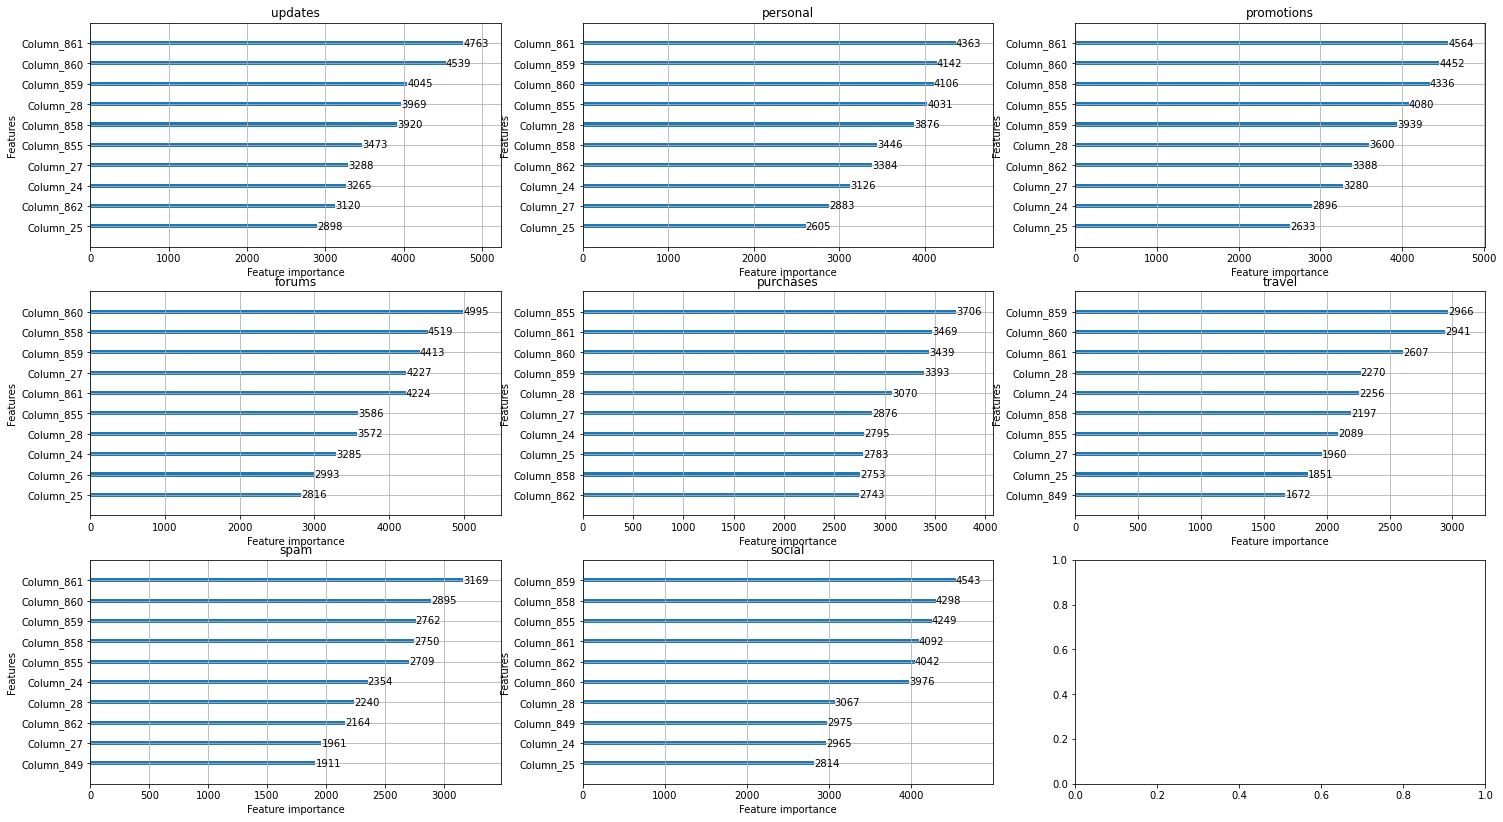

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25,14))
ax = ax.flatten()
for i,bst in enumerate(bsts):
    lgb.plot_importance(bst, ax = ax[i], max_num_features = 10 , title = labels[i])
plt.show()

In [57]:
print(log_loss(y_test["social"], bsts[7].predict(x_test)))
print(log_loss(y_test["social"], bsts[7].predict(x_test) *0.999+0.0005))

0.011089068359104544
0.011123300230089886


In [58]:
for i in range(8):
    train_data = lgb.Dataset(X, label=y[labels[i]])
    bsts[i] = lgb.train(params, train_data, num_round)

In [60]:
predictions = pd.DataFrame()
for i,label in enumerate(labels):
    predictions[label] = bsts[i].predict(X_final)
    predictions[label] *= 0.999
    predictions[label] += 0.0005
    
predictions.to_csv("LGBM_sample_submission_ml.csv", index=True, index_label='Id')

In [349]:
pd.DataFrame(X)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
0      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
39666  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39667  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
39668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
39669  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39670  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22   23    24    25    26   \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   8.0  10.0  18.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  4.0   9.0   4.0  14.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0   1.0  10.0  16.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0   8.0  10.0  20.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  10.0   7.0  15.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
39666  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  18.0  10.0  19.0   
39667  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  16.0   4.0  18.0   
39668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  18.0   4.0  17.0   
39669  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0   0.0   6.0  18.0   
39670  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  5.0   7.0   4.0  20.0   

        27   28   29   30   31   32   33   34   35   36   37   38   39   40   \
0      15.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1      17.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
2      27.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
3      16.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
4       2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
39666   8.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
39667   3.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
39668   3.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39669  14.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39670  17.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   

       41   42   43   44   45   46   47   48   49   50   51   52   53   54   \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
39666  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39667  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
39668  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39669  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
39670  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       55   56   57   58   59   60   61   62   63   64   65   66   67   68   \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [351]:
all_data

date               org  \
0      Mon, 15 Oct 2018 08:03:09 +0000 (UTC)  researchgatemail   
1      Thu, 17 Apr 2014 09:12:33 -0700 (PDT)             no-ip   
2            Thu, 27 Oct 2016 01:36:28 +0000              mail   
3      Fri, 16 Oct 2020 08:06:31 +0000 (GMT)       insideapple   
4            Thu, 02 Jul 2015 10:16:46 +0000           twitter   
...                                      ...               ...   
39666        Tue, 08 Oct 2019 18:58:39 +0000               mp1   
39667             03 Apr 2018 16:07:48 +0530                 0   
39668         Mon, 3 Apr 2017 18:55:47 +0530             iiitd   
39669        Thu, 14 Jun 2018 00:46:51 +0000                 m   
39670        Fri, 17 Apr 2020 07:06:27 -0700            github   

                     tld  ccs  bcced              mail_type  images  urls  \
0                    net    0      0  multipart/alternative       4    28   
1                    com    0      0  multipart/alternative       6    32   
2          goodreads.com    0      0        multipart/mixed       0     0   
3              apple.com    0      0  multipart/alternative     108   171   
4                    com    0      0  multipart/alternative      20   166   
...                  ...  ...    ...                    ...     ...   ...   
39666    tripadvisor.com    0      0              text/html      11    31   
39667                  0    0      0             text/plain       0     0   
39668              ac.in    0      0  multipart/alternative       0     0   
39669  mail.coursera.org    0      0  multipart/alternative      27   136   
39670                com    0      0             text/plain       0     2   

       salutations  designation  chars_in_subject  chars_in_body  updates  \
0                0            1              47.0          25556        0   
1                0            0              46.0          19930        1   
2                0            0              21.0              4        0   
3                0            0              52.0          96568        0   
4                0            0              81.0          95131        0   
...            ...          ...               ...            ...      ...   
39666            0            0              32.0          44952        0   
39667            0            0              57.0            721        1   
39668            1            0              28.0            571        0   
39669            1            1              24.0          92847        1   
39670            0            0              77.0            694        1   

       personal  promotions  forums  purchases  travel  spam  social  \
0             1           0       0          0       0     0       1   
1             1           0       0          0       0     0       0   
2             1           0       0          0       0     0       1   
3             0           1       0          0       0     0       0   
4             1           0       0          0       0     0       1   
...         ...         ...     ...        ...     ...   ...     ...   
39666         0           1       0          0       0     0       0   
39667         1           0       0          0       0     0       0   
39668         1           0       1          0       0     0       0   
39669         1           0       0          0       0     0       0   
39670         0           0       0          0       0     0       0   

       sub/body  urls/body  images/body  salutaions&designation  
0      0.001839   0.001096     0.000157                       0  
1      0.002308   0.001606     0.000301                       0  
2      5.250000   0.000000     0.000000                       0  
3      0.000538   0.001771     0.001118                       0  
4      0.000851   0.001745     0.000210                       0  
...         ...        ...          ...                     ...  
39666  0.000712   0.000690     0.000245                       0  
3966

In [277]:
data = np.random.rand(500, 100)  # 500 entities, each contains 10 features
l = np.random.randint(2, size=500)  # binary target
train_data = lgb.Dataset(data, label=l)

In [287]:
param = {'num_leaves': 100, 'objective': 'binary','verbosity':-1}
param['metric'] = 'auc'
num_round = 10
bst = lgb.train(param,train_data,num_round,)

In [284]:
from sklearn.metrics import classification_report
pre = list(       map( round,bst.predict(data) )      )
print(classification_report(l,pre))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       269
           1       0.99      0.96      0.97       231

    accuracy                           0.98       500
   macro avg       0.98      0.97      0.98       500
weighted avg       0.98      0.98      0.98       500



In [140]:
bst.best_score

defaultdict(collections.OrderedDict, {})